# Preprocesamiento y Feature Extraction (CBIR)


El sistema de Recuperación de Imágenes Basado en Contenido (CBIR) surge como una solución eficiente al permitir la búsqueda de imágenes similares basándose en sus características visuales. Este proyecto utiliza el Dogs and Cats Breed Classification Dataset, que contiene imágenes variadas de diferentes razas de perros y gatos, para desarrollar un sistema CBIR.

## Importación de Librerías y Configuración del Entorno


In [12]:
import sys
from torch.utils.data import DataLoader
from tqdm import tqdm 
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch
import torchvision.models as models
import numpy as np
from PIL import Image

src_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

from functions import *
from functions import load_cnn_model


## Carga y Exploración del Conjunto de Datos

El conjunto de datos Dogs and Cats Breed Classification Dataset se organiza en carpetas por raza. Se cargan las imágenes y se crea un DataFrame para facilitar el análisis.

Además, verificamos la distribución de clases en el dataset, asegurando que haya una representación suficiente de cada categoría, lo cual es importante para análisis y comparaciones futuras

In [13]:
# Ruta base donde se encuentran las carpetas del dataset
RAW_DIR = "../Data/raw/train"
BASE_DIR = "../Data/preprocessed"

if len(os.listdir(BASE_DIR)) == 0:  # Si está vacío, copiar
    import shutil
    for breed in os.listdir(RAW_DIR):
        shutil.copytree(os.path.join(RAW_DIR, breed), os.path.join(BASE_DIR, breed))


df = load_dataset(BASE_DIR)
print(f"Dataset cargado: {len(df)} imágenes encontradas.")
print(df.head())

Dataset cargado: 26752 imágenes encontradas.
                                            filepath             breed
0  ../Data/preprocessed\cat - abyssinian\Abyssini...  cat - abyssinian
1  ../Data/preprocessed\cat - abyssinian\Abyssini...  cat - abyssinian
2  ../Data/preprocessed\cat - abyssinian\Abyssini...  cat - abyssinian
3  ../Data/preprocessed\cat - abyssinian\Abyssini...  cat - abyssinian
4  ../Data/preprocessed\cat - abyssinian\Abyssini...  cat - abyssinian


Visualizamos algunas de las imagenes

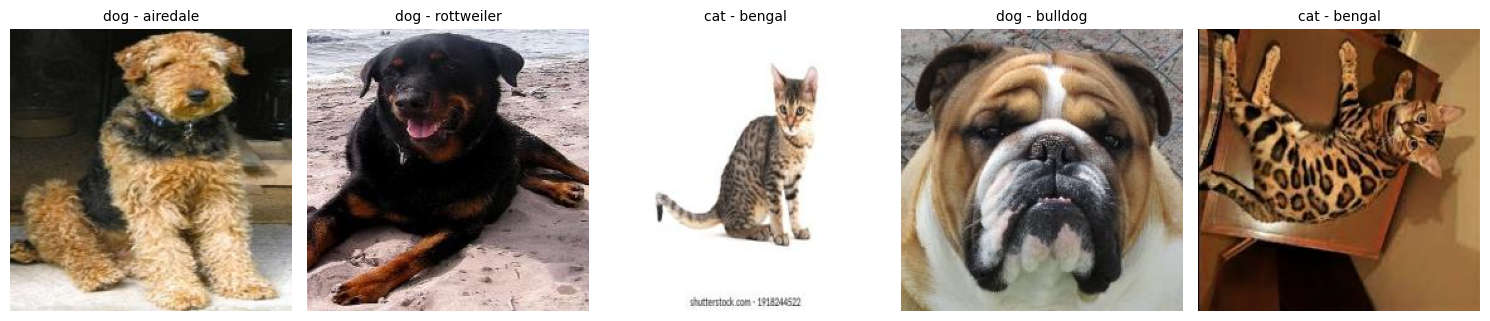

In [14]:
visualize_samples(df, total_samples=5)

Vemos cuantas imágenes tenemos de cada clase

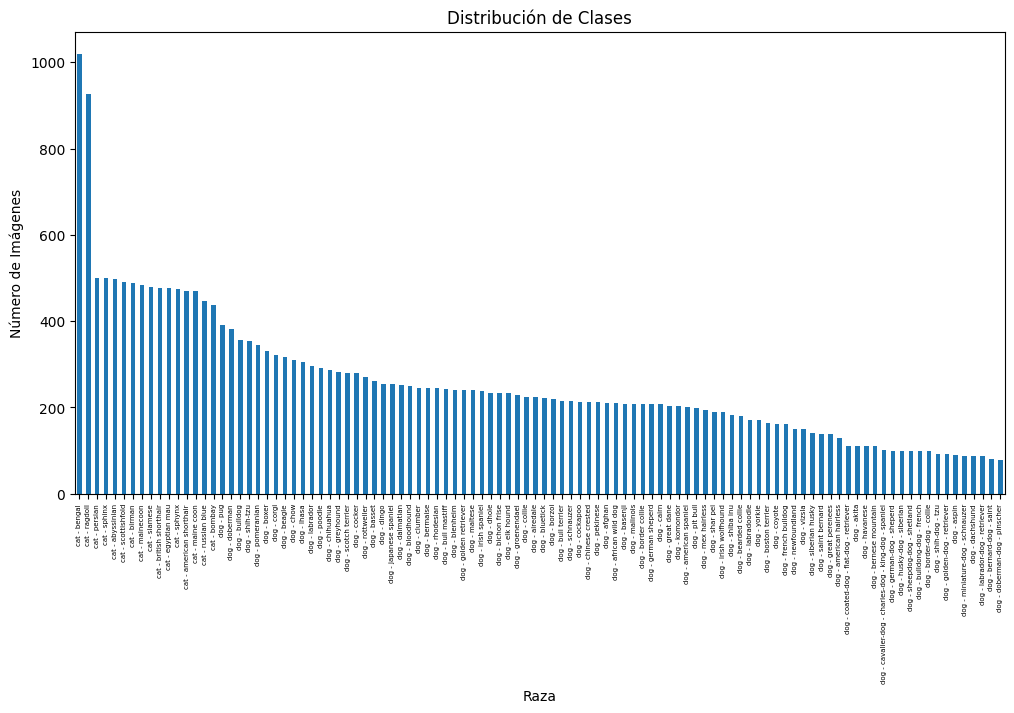

In [15]:
analyze_class_distribution(df)


Al no ser una tarea de clasificación no hay problema con que las clases estén desbalanceadas. Con este gráfico nos aseguramos de que hay suficientes muestras de cada raza de perros y gatos.

## Preprocesamiento

Se realiza un preprocesamiento para el posterior desarrollo del sistema CBIR

#### Verificacion de integridad de las imagenes

Elimina imágenes corruptas que podrían causar errores durante la carga o el procesamiento del dataset.

In [16]:
verify_images(BASE_DIR)


Total de imágenes corruptas eliminadas: 0


#### Eliminación de imágenes duplicadas

Se detectan y eliminan imágenes duplicadas para evitar sesgos en el análisis y mejorar la calidad del modelo

In [17]:
remove_duplicates(BASE_DIR)


Imagen duplicada encontrada y eliminada: ../Data/preprocessed\cat - abyssinian\Abyssinian_103_jpg.rf.b239ccdf7d61c5a8d303efbe24da6a10.jpg
Imagen duplicada encontrada y eliminada: ../Data/preprocessed\cat - abyssinian\Abyssinian_51_jpg.rf.a3651732c6cb6a5589e4c24d26f3aa3e.jpg
Imagen duplicada encontrada y eliminada: ../Data/preprocessed\cat - abyssinian\Abyssinian_58_jpg.rf.399e7dbd7c34b9a8836f9a6f0a0e13f1.jpg
Imagen duplicada encontrada y eliminada: ../Data/preprocessed\cat - abyssinian\Abyssinian_63_jpg.rf.f248e78646523ada70e18d1543e7ecd6.jpg
Imagen duplicada encontrada y eliminada: ../Data/preprocessed\cat - abyssinian\Abyssinian_79_jpg.rf.d4fa55f94ff6cd447e26505ac82b178b.jpg
Imagen duplicada encontrada y eliminada: ../Data/preprocessed\cat - abyssinian\Abyssinian_9_jpg.rf.acea5259e3a19d9ba006472afbf7504a.jpg
Imagen duplicada encontrada y eliminada: ../Data/preprocessed\cat - american shorthair\american-short-hair-kitten-260nw-330391112_jpg.rf.c20623186f98c77edecb99eec1bc939e.jpg
Imag

#### Normalización y Redimensionamiento

Se normalizan y redimensionan las imágenes a un formato estándar, mejorando la consistencia y compatibilidad con modelos preentrenados

In [18]:
# Definición de las transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Carga del conjunto de datos con las transformaciones aplicadas
dataset = ImageFolder(BASE_DIR, transform=transform)

# Creación del DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


Con estos pasos, se garantiza que el conjunto de datos esté limpio, consistente y con variaciones que ayudarán al modelo a generalizar mejor. El preprocesamiento es esencial para mejorar la calidad de las características extraídas y, en última instancia, el rendimiento del sistema CBIR.

## Extracción de Características Visuales

La extracción de características es un paso crucial en la construcción de un sistema CBIR, ya que las características extraídas representan la información visual que se utilizará para comparar y recuperar imágenes similares. 

#### Histogramas de Color
Extrae información sobre la distribución de colores en las imágenes, útil para identificar similitudes visuales relacionadas con el color

#### Descriptores de Textura (LBP - Local Binary Patterns)
Calcula patrones locales binarios que representan la textura de la imagen, capturando detalles de superficies y estructuras repetitivas

#### Momentos de Hu
Extrae características invariantes que describen la forma de los objetos en la imagen, útiles para analizar formas y contornos.

#### CNN para extracción de características
Utiliza una red neuronal convolucional preentrenada para obtener características profundas que capturan patrones complejos en las imágenes

In [19]:
model = load_cnn_model()

#### Integración y almacenamiento de características

Combinamos las características extraídas y las almacena para análisis posterior

In [20]:
df = imagefolder_to_dataframe(dataset)
print(df.head())
df.to_csv('../Data/df.csv')

                                            filepath             label
0  ../Data/preprocessed\cat - abyssinian\Abyssini...  cat - abyssinian
1  ../Data/preprocessed\cat - abyssinian\Abyssini...  cat - abyssinian
2  ../Data/preprocessed\cat - abyssinian\Abyssini...  cat - abyssinian
3  ../Data/preprocessed\cat - abyssinian\Abyssini...  cat - abyssinian
4  ../Data/preprocessed\cat - abyssinian\Abyssini...  cat - abyssinian


In [21]:
# Listas para almacenar las características
color_features = []
texture_features = []
shape_features = []
cnn_features = []
model = load_cnn_model()

# Ruta base de las imágenes
image_dir = ''

# Iterar sobre las imágenes y extraer características
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    image_name = row['filepath']
    image_path = os.path.join(image_dir, image_name)
    image = Image.open(image_path)

    color_hist = extract_color_histogram(image)
    texture_hist = extract_texture_lbp(image)
    hu_moments = extract_hu_moments(image)
    cnn_feat = extract_cnn_features(image, model)
    
    color_features.append(color_hist)
    texture_features.append(texture_hist)
    shape_features.append(hu_moments)
    cnn_features.append(cnn_feat)

color_features = np.array(color_features)
texture_features = np.array(texture_features)
shape_features = np.array(shape_features)
cnn_features = np.array(cnn_features)

np.save('../Data/processed/npy/color_features.npy', color_features)
np.save('../Data/processed/npy/texture_features.npy', texture_features)
np.save('../Data/processed/npy/shape_features.npy', shape_features)
np.save('../Data/processed/npy/cnn_features.npy', cnn_features)

  0%|          | 0/26264 [00:00<?, ?it/s]C:\Users\34676\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 26264/26264 [2:10:54<00:00,  3.34it/s]  
